---
# 📈 Single-cell protein abundance and its normalization

In [1]:
## logging functions
import logging
## data functions
import numpy as np
## data functions
import pandas as pd
## system functions
import sys
from os.path import dirname,splitext
## system functions from roux
from roux.lib.sys import basenamenoext
from roux.lib.io import to_dict,to_table
## visualization functions
import matplotlib.pyplot as plt
## visualization functions from roux
from roux.viz.diagram import diagram_nb
## visualization functions from roux
from roux.viz.io import to_plot
## data functions from roux
import roux.lib.dfs as rd # attributes
## htsimaging functions
from htsimaging.viz.image import image_regions_annotated

In [5]:
## parameters
input_path=None
segmented_image_path=None
output_path=None # table

misaligned_fraction_max=0.9
edge_off=None ## remove the cells at the edges
area_min=None
eccentricity_min=None
## plotting
figh=10

In [7]:
output_dir_path=dirname(output_path)
output_plots_dir_path=splitext(output_path)[0]+'_plots/'
logging.info(f"Output directory: {output_dir_path}")

In [8]:
diagram_nb(
"""
graph LR;
    N1(["Raw images"])
        --> channel["Pixel intensity\n(e.g. green channel)"] & seg["Segmentation\n(based on\nDIC image)"] 
        seg
            --> segdchannel_filtering["Filter the\nsegmented\nregions"]
            --> map0["Map segmentation\non pixel intensities"]
            --> segdchannel["Abundance\nby single cell"] & bkg["Background intensity"] 
            
        channel
            --> map0
        segdchannel & bkg
            --> norm0(["Normalized\nabundance\nby single cell"])
"""
)

## Segmentation

In [9]:
from htsimaging.lib.io import read_image
a0=read_image(segmented_image_path)

### Label the cells

In [10]:
from skimage import io,measure
regions=measure.label(a0)

In [11]:
ylen,xlen=regions.shape

In [12]:
np.save(f'{output_dir_path}/00_regions_raw.npy',regions)

## Properties of the cells

In [13]:
from skimage import measure

In [14]:
df_=pd.DataFrame(measure.regionprops_table( #New in version 0.16.
    label_image=regions,
    intensity_image=None,
    properties=('label', 
                'bbox', #(min_row, min_col, max_row, max_col)
                'centroid',
                'axis_major_length',
                'area', 'eccentricity',
               ), #https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    ))
df_.head(1)

label  bbox-0  bbox-1  bbox-2  bbox-3  centroid-0  centroid-1  \
0      1      13      67      61     113   35.856784   90.082915   

   axis_major_length  area  eccentricity  
0          49.832156  1592      0.569531

In [15]:
if len(df_)==0:
    sys.exit(0)

In [16]:
df_=(
    df_
    .rename(
        columns={
            'label':'cell id','bbox-0':'y1','bbox-1':'x1','bbox-2':'y2','bbox-3':'x2',
            "centroid-0":"centroid x","centroid-1":"centroid y",
            },
        errors='raise'
    )
    .assign(
        **{
            'centroid x reverse':  lambda df: xlen-df['centroid x'],
            'centroid y reverse':  lambda df: ylen-df['centroid y'],
        }
    )
)
df_.head(1)

cell id  y1  x1  y2   x2  centroid x  centroid y  axis_major_length  area  \
0        1  13  67  61  113   35.856784   90.082915          49.832156  1592   

   eccentricity  centroid x reverse  centroid y reverse  
0      0.569531          589.143216          534.917085

In [17]:
to_table(df_,f'{output_dir_path}/01_properties.tsv')

'outputs/01_properties.tsv'

### Remove the cells at the edges

In [18]:
def filter_cellsby_properties(
    edge_cells,
    regions,
    ):
    print(len(edge_cells))
    regions_filtered=regions.copy()
    for i in edge_cells:
        regions_filtered[regions_filtered==i]=0
        
    ## plot
    fig,axs=plt.subplots(1,2,figsize=[12,6])
    axs[0].imshow(
        regions>0,
        cmap='Greys_r')
    axs[0].set(title='before')
    axs[1].imshow(
        regions_filtered>0,
        cmap='Greys_r')
    axs[1].set(title='after')    
    return regions_filtered

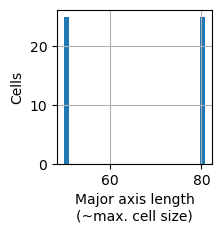

In [19]:
plt.subplots(figsize=[2,2])
_=df_['axis_major_length'].hist(bins=30).set(xlabel='Major axis length\n(~max. cell size)',ylabel='Cells')

In [20]:
if edge_off is None:
    edge_off=df_['axis_major_length'].median()
    print(edge_off)

0


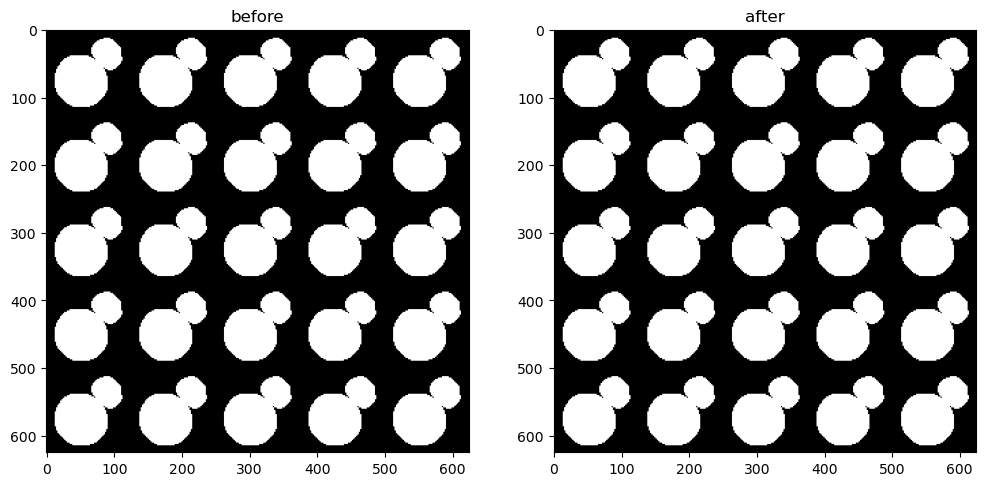

In [21]:
regions_filtered=filter_cellsby_properties(
    edge_cells=df_.set_index('cell id').filter(regex="^centroid.*").apply(lambda x: x<edge_off).any(axis=1).loc[lambda x: x].index.tolist(),
    regions=regions,
    )

### Remove the small regions

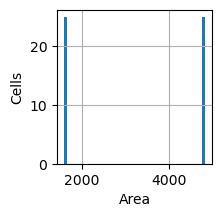

In [22]:
plt.subplots(figsize=[2,2])
_=df_['area'].hist(bins=50).set(xlabel='Area',ylabel='Cells')

In [23]:
if not area_min is None:
    regions_filtered=filter_cellsby_properties(
        edge_cells=df_.log.query(expr=f"`area`<={area_min}")['cell id'].unique().tolist(),
        regions=regions_filtered,
        )

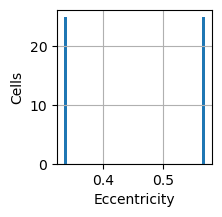

In [24]:
plt.subplots(figsize=[2,2])
_=df_['eccentricity'].hist(bins=50).set(xlabel='Eccentricity',ylabel='Cells')

In [25]:
if not eccentricity_min is None:
    regions_filtered=filter_cellsby_properties(
        edge_cells=df_.log.query(expr=f"`eccentricity`<={eccentricity_min}")['cell id'].unique().tolist(),
        regions=regions_filtered,
        )

In [26]:
to_dict(
    dict(
        edge_off=edge_off,
        area_min=area_min,
        eccentricity_min=eccentricity_min,
    ),
     f"{output_dir_path}/01_regions_filtered_stats.json",
)

'outputs/01_regions_filtered_stats.json'

In [27]:
np.save(f'{output_dir_path}/01_regions_filtered.npy',regions_filtered)

## Segmentations mapped onto the raw intensity image

In [28]:
## Channel image
a1=read_image(input_path)

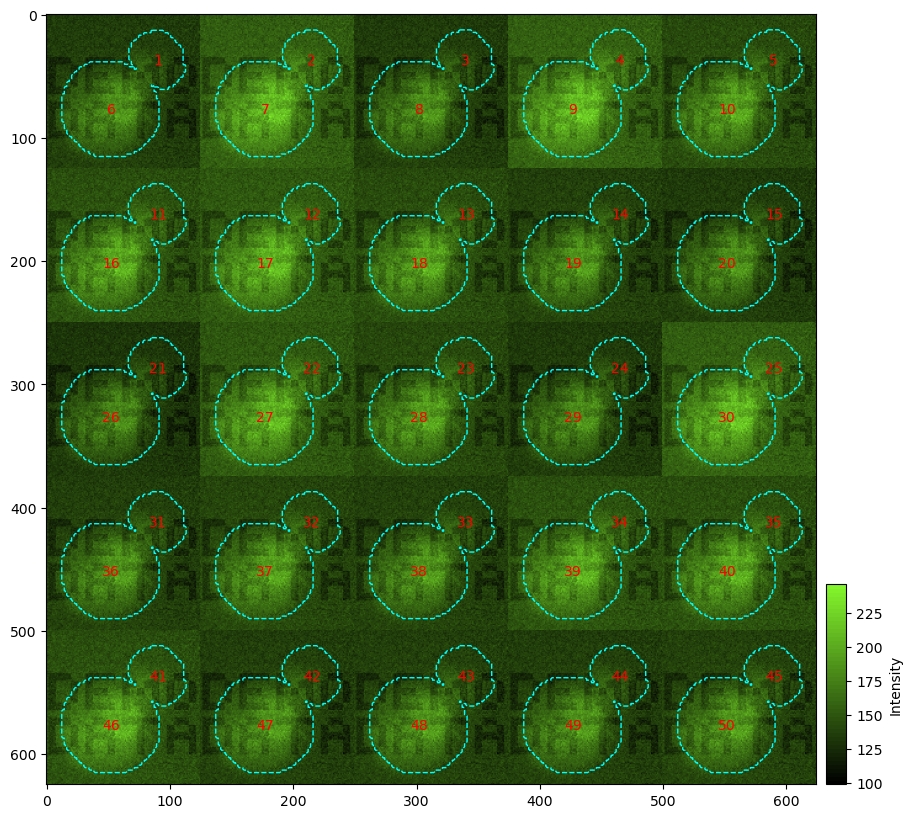

In [29]:
fig,ax=plt.subplots(
    figsize=[figh,figh],
    )
image_regions_annotated(
    img_region=regions_filtered,
    img=a1,
    img_label=regions, ## labels
    cmap='gfp',
    ax=ax,
    )
_=to_plot(f"{output_plots_dir_path}/{basenamenoext(input_path)}_with_segmentation.png")

## Background intensity

### Identification

In [30]:
from skimage.segmentation import expand_labels

In [31]:
regions_expanded=expand_labels(
    regions, # unfiltered
    distance=edge_off,
    )

In [32]:
np.save(f'{output_dir_path}/00_regions_expanded.npy',regions_expanded)

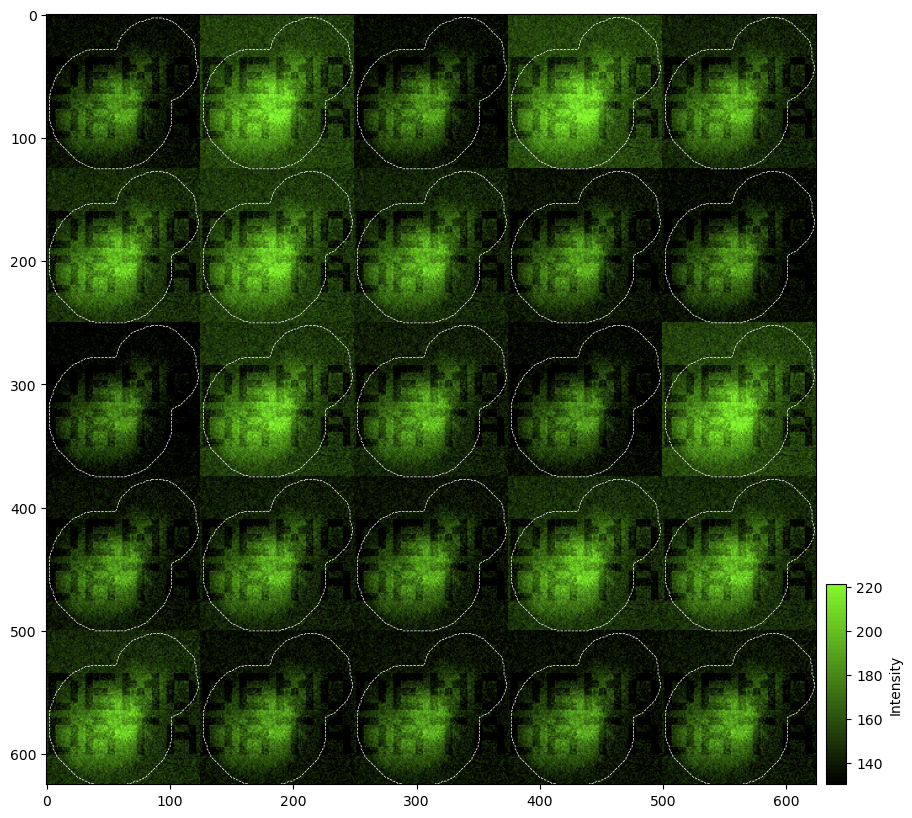

In [33]:
fig,ax=plt.subplots(1,1,figsize=[figh,figh])
from htsimaging.viz.image import image_background
image_background(
    img_region=regions_expanded,
    img=a1,
    cmap='gfp',
    alpha=1,
    linewidths=0.5,
    colors='w',
    kws_region={},
    show_scalebar=None,
    scalebar_color='w',
    test=False,
    ax=ax,
    vmin=np.quantile(a1,0.1),
    vmax=np.quantile(a1,0.999),
    # **kws_img,
    )
## only regions
# ax.imshow(
#     regions_expanded>0,
#     cmap='Greys_r')
_=to_plot(f"{output_plots_dir_path}/{basenamenoext(input_path)}_background.png")

In [34]:
df_=(pd.DataFrame({
    'cell id':regions_expanded.ravel(),
    'intensity':a1.ravel(),
    })
    .query(f"`cell id` == 0") ## get background
    )
df_.head(1)

cell id   intensity
0        0  132.215809

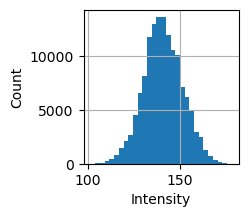

In [35]:
plt.subplots(figsize=[2,2])
_=df_['intensity'].hist(bins=30).set(xlabel='Intensity',ylabel='Count')

In [36]:
df_['intensity'].describe().astype(int)

count    137825
mean        140
std          10
min         101
25%         133
50%         140
75%         147
max         177
Name: intensity, dtype: int64

In [37]:
_background_intensity=df_['intensity'].median()

### Interpolate the background image

In [38]:
def interpolate(image,test=False):
    from scipy import interpolate
    valid_mask = ~np.isnan(image)
    coords = np.array(np.nonzero(valid_mask)).T
    values = image[valid_mask]
    
    it = interpolate.LinearNDInterpolator(coords, values, fill_value=np.nanmean(image))
    filled = it(list(np.ndindex(image.shape))).reshape(image.shape)
    if test:
        ## plot
        plt.imshow(filled,
              )
    return filled
img_bkg=a1.copy().astype(float)
img_bkg[regions_expanded!=0]=np.nan
img_bkg_filled=interpolate(img_bkg)

In [39]:
def gaussian_smoothing(
    image,
    sigma,
    test=False,
    ):
    from scipy.ndimage import gaussian_filter
    smoothed_image = gaussian_filter(image, sigma=sigma, mode='nearest')
    if test:
        ## plot
        plt.imshow(smoothed_image,
              )
    return smoothed_image
img_bkg_smooth=gaussian_smoothing(img_bkg_filled, sigma=20)

### Cell-wise background intensity

In [40]:
df0=(pd.DataFrame({
        'cell id':regions_filtered.ravel(),
        'background intensity':img_bkg_smooth.ravel(),
    })
    .log.query(expr=f"`cell id` != 0") ## remove background
    .log('cell id')
    .groupby('cell id')
        .agg(
            **{
                "background intensity":("background intensity",np.median),
            })
    .reset_index()
    )
df0.head(1)

cell id  background intensity
0        1            136.629297

In [41]:
if len(df0)==0:
    sys.exit(0)

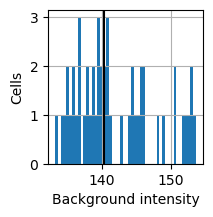

In [42]:
fig,ax=plt.subplots(figsize=[2,2])
_=df0['background intensity'].hist(bins=50,ax=ax)
ax.set(xlabel='Background intensity',ylabel='Cells')
ax.axvline(_background_intensity,color='k')

#### Plot

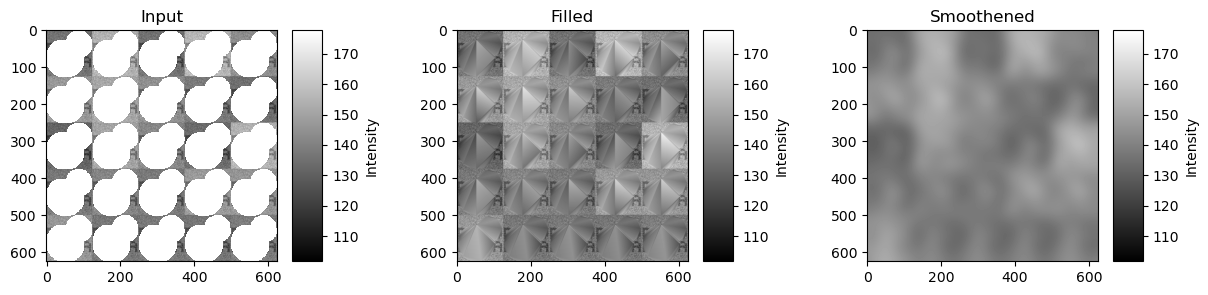

In [43]:
fig,axs=plt.subplots(1,3,figsize=[15,3])
for ax, (title,im) in zip(axs,{'Input':img_bkg,'Filled':img_bkg_filled,'Smoothened':img_bkg_smooth}.items()):
    image_background(
        img=im,
        cmap='binary_r',
        alpha=1,
        kws_region={},
        show_scalebar=None,
        scalebar_color='w',
        vmin=np.nanmin(img_bkg),
        vmax=np.nanmax(img_bkg),
        ax=ax,
        )
    ax.set(title=title)

### Output

In [44]:
np.save(f'{output_dir_path}/00_img_bkg_smooth.npy',img_bkg_smooth)

## Map the segmentation to the filtered segmentation

In [45]:
df1=(pd.DataFrame({
    'cell id':regions_filtered.ravel(),
    'intensity':a1.ravel(),
    })
    .log.query(expr=f"`cell id` != 0") ## remove background
    .log('cell id')
    )
df1.head(1)

cell id   intensity
8210        1  140.715396

### Check for the alignment between the segmentation and the channel

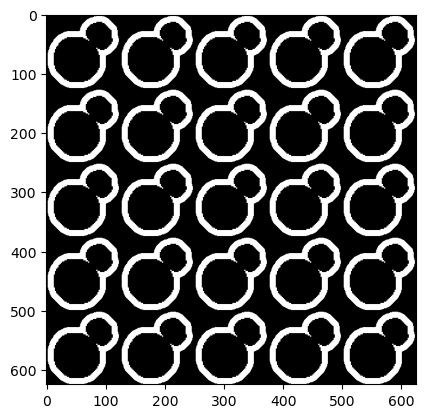

In [46]:
regions_expanded_areas=(regions==0) & (regions_expanded!=0)
plt.imshow(regions_expanded_areas,cmap='Greys_r')

In [47]:
## get channel intensity in the expanded areas
df_=(pd.DataFrame({
    'area':regions_expanded_areas.ravel(),
    'intensity':a1.ravel(), ## channel intensity
    })
    .query(f"`area` == True") ## get background
    )
df_.head(1)

area   intensity
1960  True  134.104606

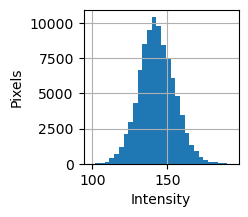

In [48]:
plt.subplots(figsize=[2,2])
_=df_['intensity'].hist(bins=30).set(xlabel='Intensity',ylabel='Pixels')

In [49]:
misaligned_area_intensity=df_['intensity'].median()

In [50]:
misaligned_fraction=(misaligned_area_intensity/df1['intensity'].median())
print(misaligned_fraction)

0.8933414413295823


In [51]:
if misaligned_fraction>=misaligned_fraction_max:
    logging.warning("Possible misalignment between he segmentation and the channel")

### Abundance by single cell

In [52]:
df2=(df1
    .groupby('cell id')
    .agg(
        **{
            "abundance":("intensity",np.median),
        })
    .reset_index()
    .log.merge(
        right=df0,
        on='cell id',
        how='inner',
        validate="1:1",
        )
    ## normalize
    .assign(
          **{
              'abundance normalized':lambda df: df.apply(lambda x: x['abundance']/x['background intensity'],axis=1),
              'abundance normalized by image':lambda df: df.apply(lambda x: x['abundance']/_background_intensity,axis=1),
          }
    )
    )
df2.head(1)

cell id   abundance  background intensity  abundance normalized  \
0        1  139.770998            136.629297              1.022994   

   abundance normalized by image  
0                       0.995994

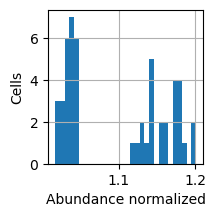

In [53]:
plt.subplots(figsize=[2,2])
_=df2['abundance normalized'].hist(bins=30).set(xlabel='Abundance normalized',ylabel='Cells')

In [54]:
## save stats
to_dict(
    dict(
        background_intensity=_background_intensity,
        misaligned_area_intensity=misaligned_area_intensity,
        misaligned_fraction=misaligned_fraction,
    ),
     f"{splitext(output_path)[0]}_stats.json",
)

'outputs/test_stats.json'

In [55]:
## save table with abundances
to_table(df2,output_path)

'outputs/test.npy'

## Segmentations mapped onto the normalized intensity image

### Cell-wise normalization

In [56]:
## Channel image
img_bkg_norm=a1/img_bkg_smooth

In [57]:
## save the normalized image
np.save(f'{output_dir_path}/02_img_bkg_norm.npy',img_bkg_norm)

### Global normalization

In [58]:
## Channel image
img_bkg_normby_image=a1/_background_intensity

In [59]:
## save the normalized image
np.save(f'{output_dir_path}/02_img_bkg_normby_image.npy',img_bkg_normby_image)

## Plot comparison

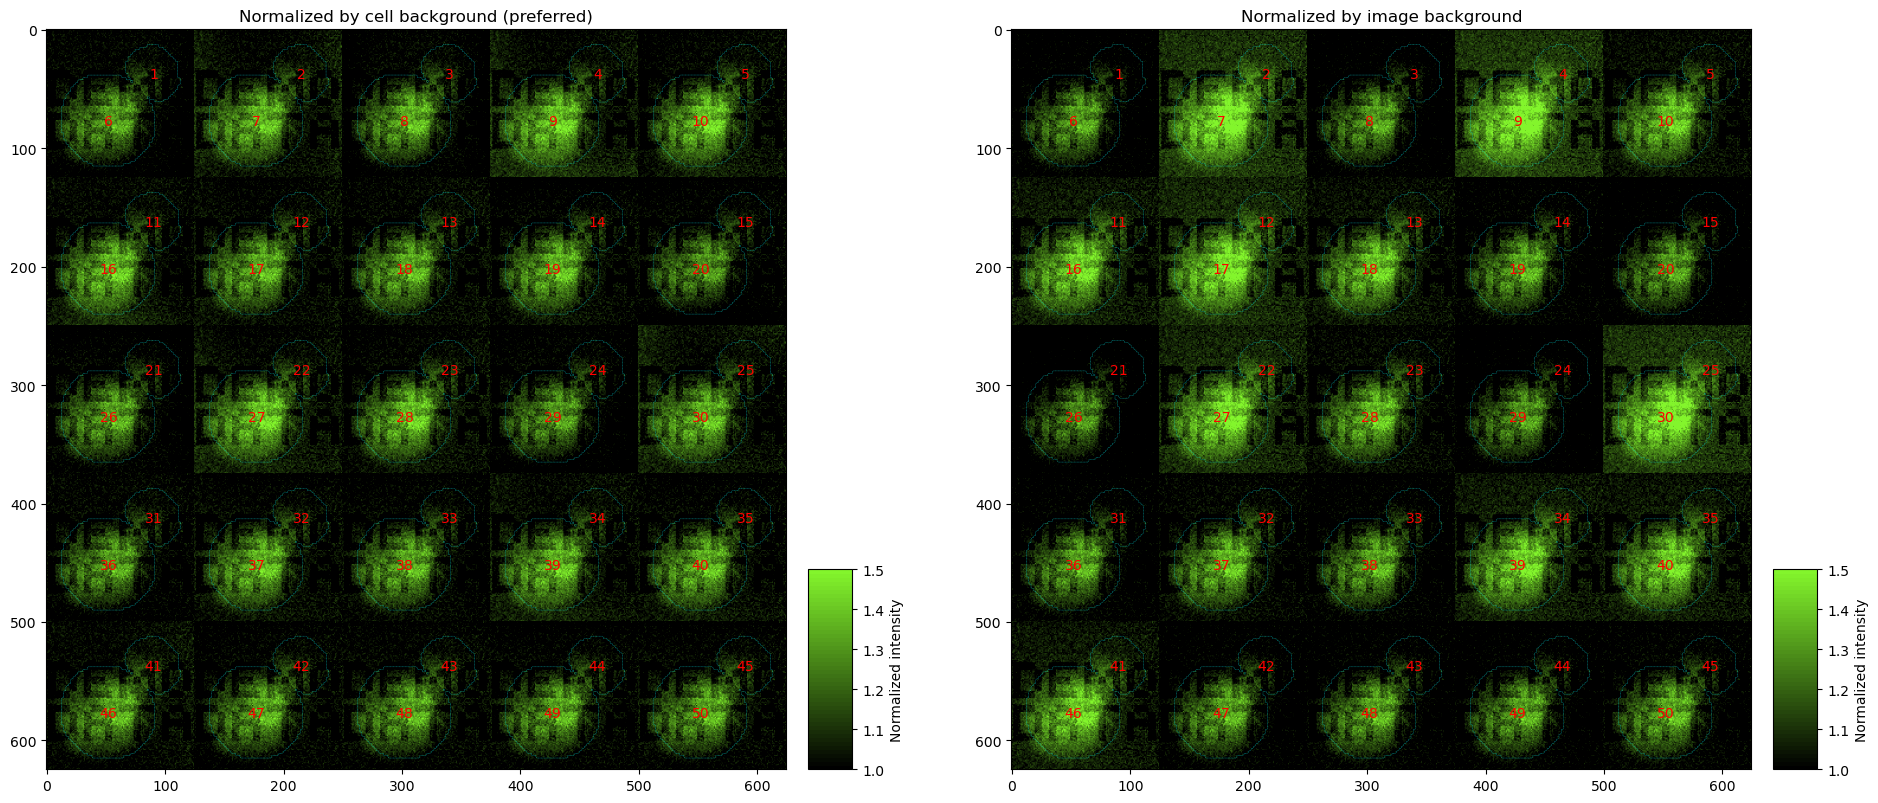

In [64]:
fig=plt.figure(figsize=[figh*2.2,figh])
axs=[
     plt.subplot2grid([1,9],[0,0],1,4),
     plt.subplot2grid([1,9],[0,5],1,4),
    ]
for ax, title, _img in zip(axs,
                                # ['bkg_normed','bkg_normedby_image'],
                                ['Normalized by cell background (preferred)','Normalized by image background'],
                                [img_bkg_norm,img_bkg_normby_image]):
    image_regions_annotated(
        img=_img,
        img_label=regions, ## labels
        img_region=regions_filtered, ## outlines
        cmap='gfp',
        vmin=1,
        vmax=1.5,
        linewidths=0.2,
        cbar_label="Normalized intensity",
        ax=ax,
        )
    ax.set(title=title)
_=to_plot(f"{output_plots_dir_path}/{basenamenoext(input_path)}_with_segmentation_bkg_normed.png")